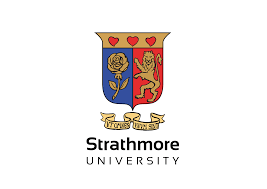

# Project Title

Optimizing agroforestry for climate resilience: A data-driven approach to mitigating environmental shocks and enhancing ecosystem stability

# Objective of the Study
The Objective is to develop machine learning models for optimizing agroforestry systems through species identification, classification, and Carbon sequestration valuation to enhance climate change mitigation and adaptation.

i.	Assess and quantify the potential for carbon sequestration within agroforestry systems using advanced ML techniques, supporting efforts to mitigate climate change.

ii.	To develop machine learning models for species identification and classification within agroforestry systems, enhancing biodiversity management.

iii. To develop a smart decision support system that combines ecological, climate, and species data, providing actionable recommendations in real time to farmers based on climate predictions, soil data, and agroforestry performance metrics.


# Introduction

In this Notebook we are developing machine learning models for species identification and classification within agroforestry systems. We have choose four species to reduce the time needed to train and hyper parameter tuning.

# Relevant Python Libraries

In [4]:
# Required packages
import pandas as pd  # Load and preprocess data.
import os  # Manage file paths and directories.
import requests  # Send HTTP requests to interact with web APIs or download content from the internet.
import io  # Provides tools for working with I/O streams.
import matplotlib.pyplot as plt  # Create static visualizations like line plots, bar charts, and scatter plots.
import seaborn as sns  # Create enhanced statistical data visualizations like heatmaps and pair plots.
import plotly.express as px  # Quickly create interactive visualizations like scatter plots, line charts, and maps.
import plotly.graph_objects as go  # Build detailed and customized interactive visualizations.
import numpy as np  # Perform numerical operations on arrays and matrices efficiently.
import math  # Perform basic mathematical calculations like logarithms and trigonometric functions.
import ee  # Use Google Earth Engine for large-scale geospatial analysis and satellite data processing.
import scipy.stats as stats  # Perform statistical functions and hypothesis testing.
import folium
import geopandas as gpd
from shapely.geometry import Point
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, cohen_kappa_score, f1_score, precision_score, recall_score, matthews_corrcoef)
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Importing data from my Github



In [5]:
url = 'https://raw.githubusercontent.com/irungus/Dessertation/main/final_data.csv'
df = pd.read_csv(url, on_bad_lines='skip')

# Visualizing the spatial distribution of the tree species within Kenya

In [6]:
# Convert DataFrame to GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # WGS 84 CRS

# Create a Folium map centered around the first point
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)

# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=1
    ).add_to(m)

    # Add buffer as a circular region
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=row['accuracy'],  # Accuracy column as buffer (meters)
        color="red",
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

# Display the map
m


I want to see how the three species are

--2025-04-11 04:47:49--  https://raw.githubusercontent.com/irungus/Dessertation/main/Counties.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1919228 (1.8M) [application/zip]
Saving to: ‘Counties.zip’

Counties.zip        100%[===================>]   1.83M  --.-KB/s    in 0.05s   

2025-04-11 04:47:50 (39.9 MB/s) - ‘Counties.zip’ saved [1919228/1919228]

Archive:  Counties.zip
  inflating: Counties/County.dbf     
  inflating: Counties/County.prj     
  inflating: Counties/County.sbn     
  inflating: Counties/County.sbx     
  inflating: Counties/County.shp     
  inflating: Counties/County.shp.xml  
  inflating: Counties/County.shx     


<ipython-input-7-942f0cdc4746>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {genus: plt.cm.get_cmap('tab10', len(unique_genera))(i) for i, genus in enumerate(unique_genera)}


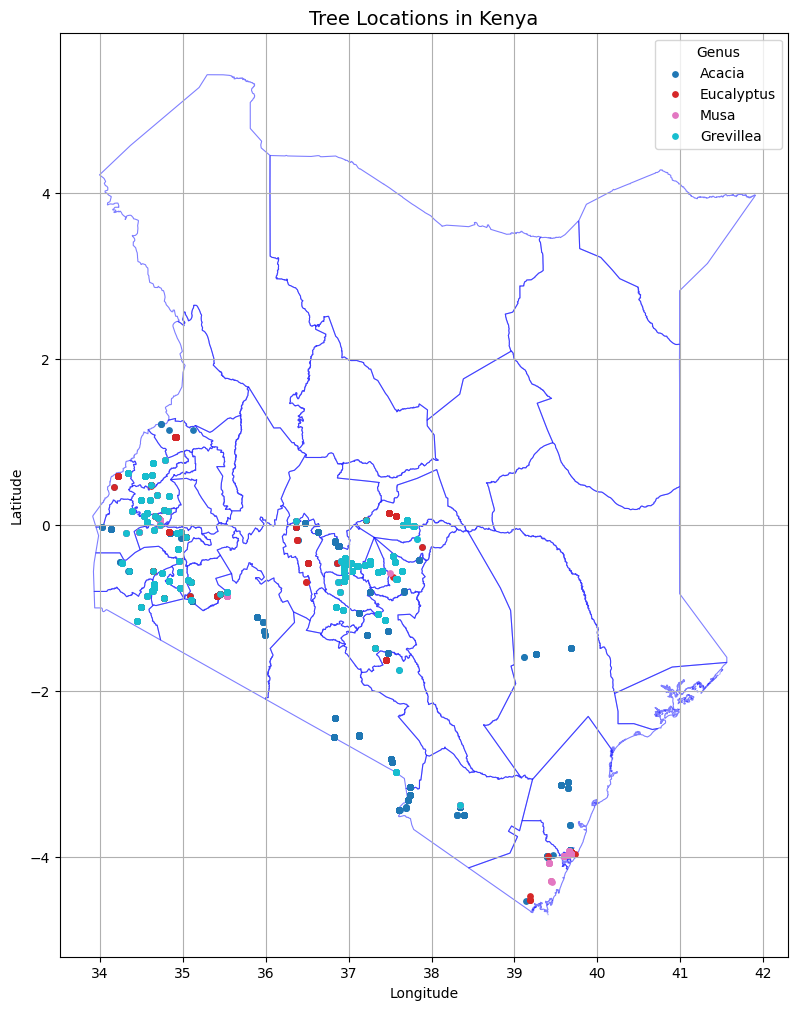

In [7]:
# Using Kenya counties shapefile from GitHub
zip_url = "https://raw.githubusercontent.com/irungus/Dessertation/main/Counties.zip"
!wget {zip_url} -O Counties.zip
!unzip -o Counties.zip -d Counties

# Load the shapefile
shp_path = "Counties/County.shp"
kenya_counties = gpd.read_file(shp_path)

#Prepare the tree GeoDataFrame from df
# Convert DataFrame to GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Convert accuracy column to buffer circles
gdf['buffer'] = gdf.apply(lambda row: row.geometry.buffer(row['accuracy'] / 111320), axis=1)

# Assign a color for each tree genus
unique_genera = gdf['genus'].unique()
color_map = {genus: plt.cm.get_cmap('tab10', len(unique_genera))(i) for i, genus in enumerate(unique_genera)}

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Kenya counties
kenya_counties.plot(ax=ax, color="none", edgecolor="blue", linewidth=0.8, alpha=0.5)

# Plot buffers and points by genus
for genus in unique_genera:
    genus_gdf = gdf[gdf['genus'] == genus]
    genus_gdf.set_geometry('buffer').plot(ax=ax, color=color_map[genus], alpha=0.3, edgecolor='black')
    genus_gdf.set_geometry('geometry').plot(ax=ax, markersize=15, color=color_map[genus], label=genus, marker="o")

# Map settings
plt.title("Tree Locations in Kenya", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Genus", fontsize=10)
plt.grid(True)

plt.show()

# Data Exploration

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FID                     3071 non-null   int64  
 1   agf                     3071 non-null   object 
 2   plotID                  3071 non-null   int64  
 3   transect                3071 non-null   int64  
 4   County                  3071 non-null   object 
 5   genus                   3071 non-null   object 
 6   species                 3071 non-null   object 
 7   dbh                     3071 non-null   int64  
 8   height                  3071 non-null   int64  
 9   canopyd                 3071 non-null   int64  
 10  latitude                3071 non-null   float64
 11  longitude               3071 non-null   float64
 12  altitude                3071 non-null   float64
 13  accuracy                3071 non-null   float64
 14  B11                     3071 non-null   

In [9]:
df.columns

Index(['FID', 'agf', 'plotID', 'transect', 'County', 'genus', 'species', 'dbh',
       'height', 'canopyd', 'latitude', 'longitude', 'altitude', 'accuracy',
       'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9',
       'NDVI', 'EVI', 'NDWI', 'RDVI', 'NDVI_red_edge', 'mNDVI_red_edge',
       'MSR_red_edge', 'CI_red_edge', 'MSI', 'LSWI', 'MTCI', 'IRECI', 'PSRI',
       'NDVIA', 'TCARI', 'MCARI', 'TVI', 'SAVI', 'Temp_mean', 'Temp_max',
       'Temp_min', 'Temp_skew', 'Temp_kurtosis', 'Elevation_x', 'Precip_mean',
       'Precip_max', 'Precip_min', 'Precip_skew', 'Precip_kurtosis',
       'Elevation_y', 'Slope', 'Aspect', 'Hill_shade', 'VV', 'VH',
       'Backscatter_Difference', 'Backscatter_Division',
       'Backscatter_Amplitude', 'NIR_Contrast', 'NIR_Dissimilarity',
       'NIR_Entropy', 'NIR_Correlation', 'NIR_ASM', 'NIR_Inertia', 'NIR_Shade',
       'NIR_Prominence', 'geometry'],
      dtype='object')

In [10]:
df.describe()

FID   plotID  transect      dbh   height  canopyd  latitude  \
count 3,071.00 3,071.00  3,071.00 3,071.00 3,071.00 3,071.00  3,071.00   
mean  3,267.88   108.66      2.51    45.12   828.67   326.60     -0.87   
std   2,094.87    49.16      1.29    43.12   639.90   257.42      1.18   
min       0.00     0.00      1.00     5.00    80.00    17.00     -4.54   
25%   1,569.50    71.00      1.00    20.00   400.00   130.00     -1.06   
50%   3,111.00   115.00      2.00    35.00   680.00   300.00     -0.56   
75%   4,699.50   152.00      4.00    55.00 1,100.00   420.00     -0.08   
max   7,102.00   184.00      4.00   390.00 5,000.00 2,700.00      1.22   

       longitude  altitude  accuracy  ...  Backscatter_Division  \
count   3,071.00  3,071.00  3,071.00  ...              3,071.00   
mean       36.42  1,481.07      4.46  ...                  0.59   
std         1.49    488.41      0.85  ...                  0.10   
min        34.02    -67.60      0.72  ...                 -0.72   
25%        34.83  1,269.40      4.46  ...                  0.54   
50%        36.94  1,524.80      4.78  ...                  0.60   
75%        37.47  1,814.00      4.92  ...                  0.66   
max        39.73  2,482.40      5.85  ...                  0.88   

       Backscatter_Amplitude           NIR_Contrast  NIR_Dissimilarity  \
count               3,071.00               3,071.00           3,071.00   
mean                   17.97  10,682,918,635,142.37       2,353,838.57   
std                     2.86  11,404,179,855,618.97       1,262,533.04   
min                     5.71      17,361,191,860.00         109,772.29   
25%                    16.10   3,047,215,000,000.00       1,408,694.10   
50%                    17.81   7,409,560,000,000.00       2,210,746.83   
75%                    19.65  13,940,550,000,000.00       3,086,890.67   
max                    29.83 116,874,000,000,000.00       9,112,654.67   

       NIR_Entropy  NIR_Correlation  NIR_ASM            NIR_Inertia  \
count     3,071.00         3,071.00 3,071.00               3,071.00   
mean          2.28             0.01     0.11  10,682,918,635,142.37   
std           0.03             0.16     0.00  11,404,179,855,618.97   
min           2.01            -0.48     0.10      17,361,191,860.00   
25%           2.28            -0.10     0.10   3,047,215,000,000.00   
50%           2.28             0.02     0.10   7,409,560,000,000.00   
75%           2.28             0.13     0.10  13,940,550,000,000.00   
max           2.28             0.41     0.14 116,874,000,000,000.00   

                            NIR_Shade  \
count                        3,071.00   
mean      -271,743,929,332,888,192.00   
std     42,411,163,211,526,823,936.00   
min   -828,000,000,000,000,000,000.00   
25%     -4,315,000,000,000,000,000.00   
50%          6,840,470,000,000,000.00   
75%      4,645,000,000,000,000,000.00   
max    449,000,000,000,000,000,000.00   

                                 NIR_Prominence  
count                                  3,071.00  
mean     811,996,691,166,395,348,029,538,304.00  
std    2,129,279,294,859,517,995,801,116,672.00  
min              892,000,000,000,000,000,000.00  
25%       24,749,999,999,999,994,350,272,512.00  
50%      149,999,999,999,999,998,557,159,424.00  
75%      633,499,999,999,999,957,427,814,400.00  
max   43,400,000,000,000,002,720,727,564,288.00  

[8 rows x 67 columns]

In [11]:
# List of columns to drop
columns_to_drop = ['FID', 'agf', 'plotID', 'transect', 'County', 'species', 'geometry']

# Drop them from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)

In [12]:
df_cleaned.head()

genus  dbh  height  canopyd  latitude  longitude  altitude  accuracy  \
0      Acacia   26     600      450     -4.54      39.14     50.77      0.92   
1  Eucalyptus   65    1160      680     -4.52      39.18     -1.43      0.79   
2  Eucalyptus   35     890      390     -4.52      39.18     -2.64      0.99   
3  Eucalyptus   24     810      390     -4.52      39.18     -1.66      0.88   
4  Eucalyptus   65    1000      430     -4.47      39.19     97.52      1.63   

       B11      B12  ...  Backscatter_Division  Backscatter_Amplitude  \
0 2,512.00 1,599.00  ...                  0.83                  20.40   
1 2,724.00 1,758.00  ...                  0.66                  18.06   
2 2,724.00 1,758.00  ...                  0.66                  18.06   
3 2,724.00 1,758.00  ...                  0.64                  18.53   
4 2,559.50 1,728.50  ...                  0.68                  18.44   

           NIR_Contrast  NIR_Dissimilarity  NIR_Entropy  NIR_Correlation  \
0 19,884,400,000,000.00       3,868,333.33         2.28             0.13   
1  3,262,890,000,000.00       1,482,083.33         2.28             0.01   
2  3,262,890,000,000.00       1,482,083.33         2.28             0.01   
3  3,181,330,000,000.00       1,455,297.62         2.28            -0.07   
4  4,900,680,000,000.00       1,898,750.00         2.28            -0.27   

   NIR_ASM           NIR_Inertia                     NIR_Shade  \
0     0.10 19,884,400,000,000.00 69,000,000,000,000,000,000.00   
1     0.10  3,262,890,000,000.00 -1,190,000,000,000,000,000.00   
2     0.10  3,262,890,000,000.00 -1,190,000,000,000,000,000.00   
3     0.10  3,181,330,000,000.00   -818,000,000,000,000,000.00   
4     0.10  4,900,680,000,000.00 -1,100,000,000,000,000,000.00   

                            NIR_Prominence  
0 1,280,000,000,000,000,115,964,116,992.00  
1    21,499,999,999,999,999,907,725,312.00  
2    21,499,999,999,999,999,907,725,312.00  
3    16,299,999,999,999,998,062,231,552.00  
4    20,299,999,999,999,997,995,122,688.00  

[5 rows x 65 columns]

In [13]:
df_cleaned['genus'].value_counts()

genus
Acacia        999
Grevillea     876
Eucalyptus    686
Musa          510
Name: count, dtype: int64

In [14]:
df_cleaned.isna().sum()

genus              0
dbh                0
height             0
canopyd            0
latitude           0
                  ..
NIR_Correlation    0
NIR_ASM            0
NIR_Inertia        0
NIR_Shade          0
NIR_Prominence     0
Length: 65, dtype: int64

<Axes: >

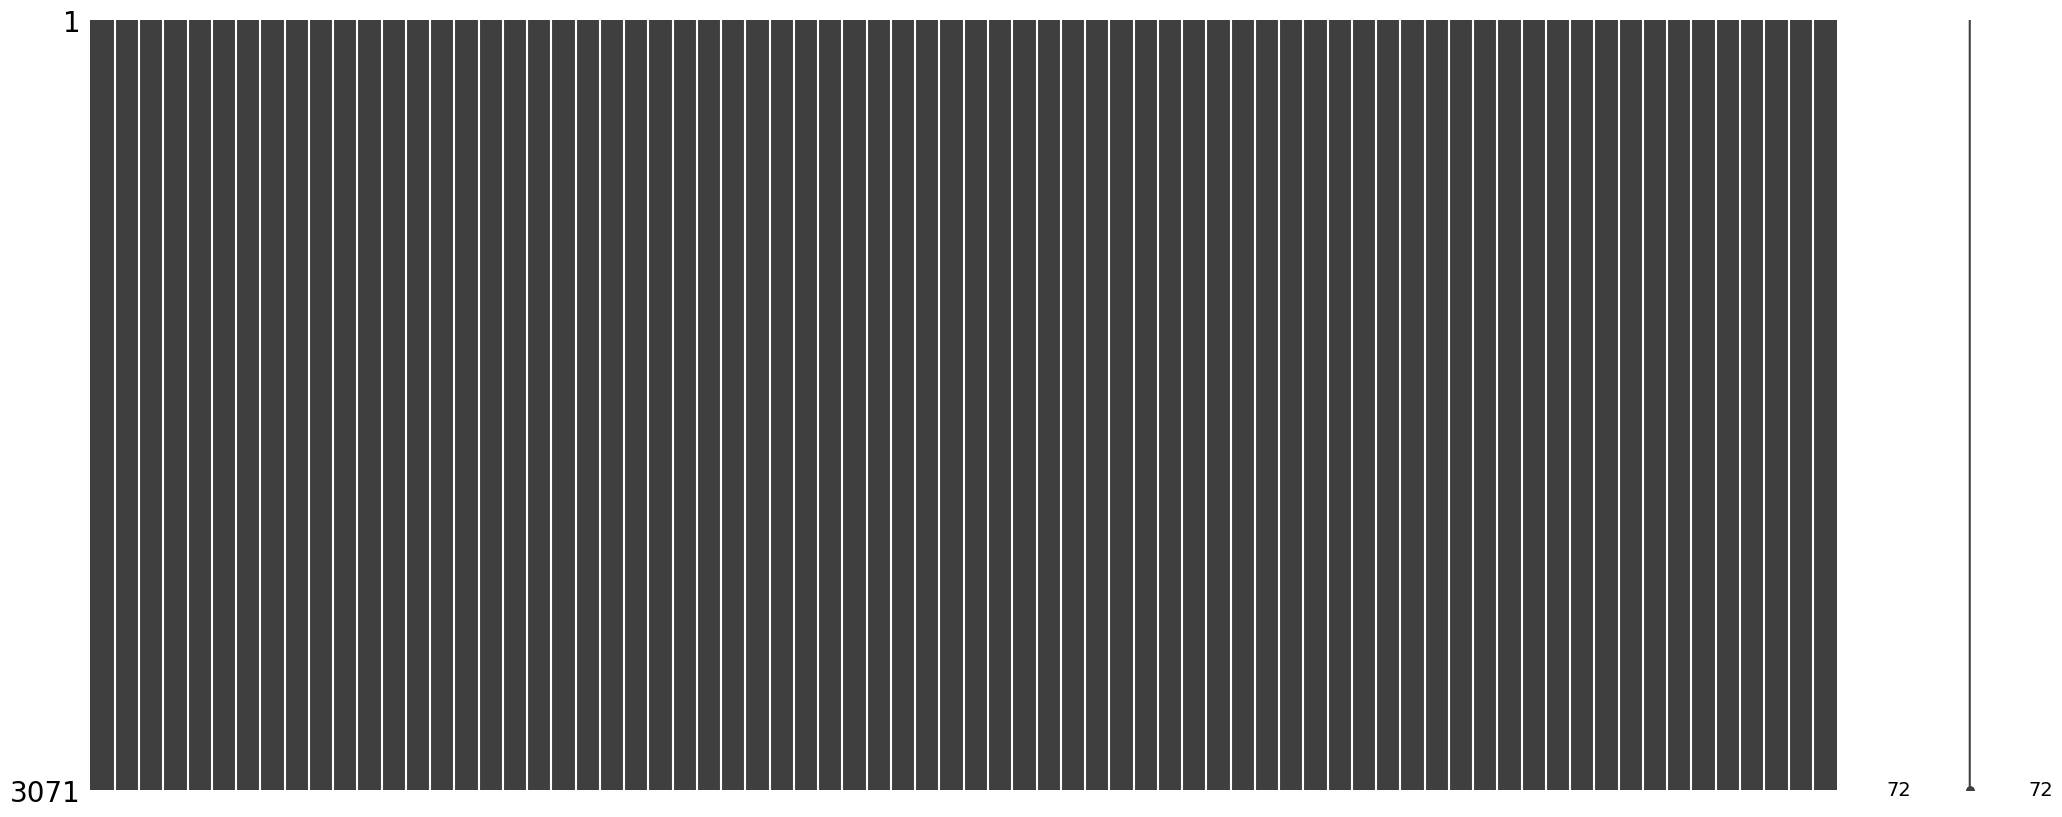

In [15]:
import missingno as msno
msno.matrix(df)

# Box plots
To check if there are outliers

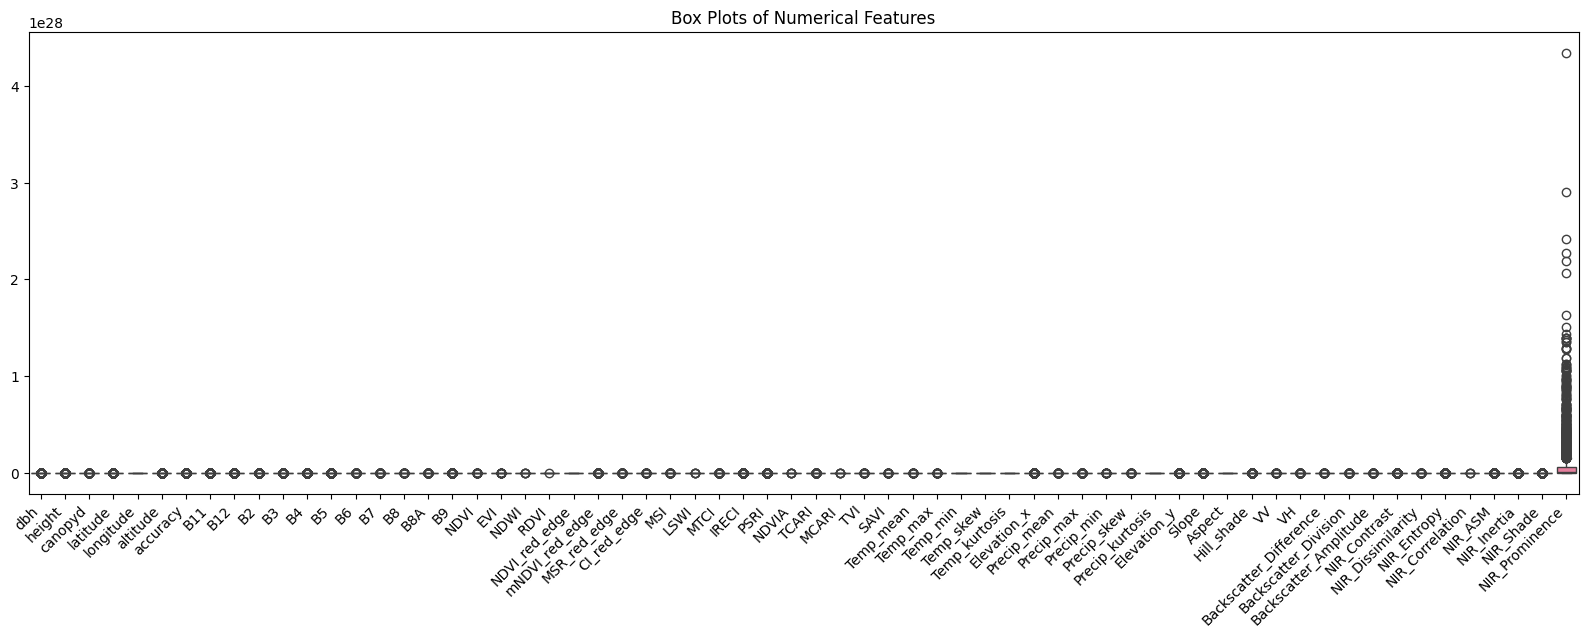

In [16]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df_cleaned)
plt.xticks(rotation=45, ha='right')
plt.title('Box Plots of Numerical Features')
plt.show()


In [ ]:
numeric_df = df_cleaned.select_dtypes(include=np.number)
correlations = numeric_df.corr()
correlations.to_csv('correlations.csv')

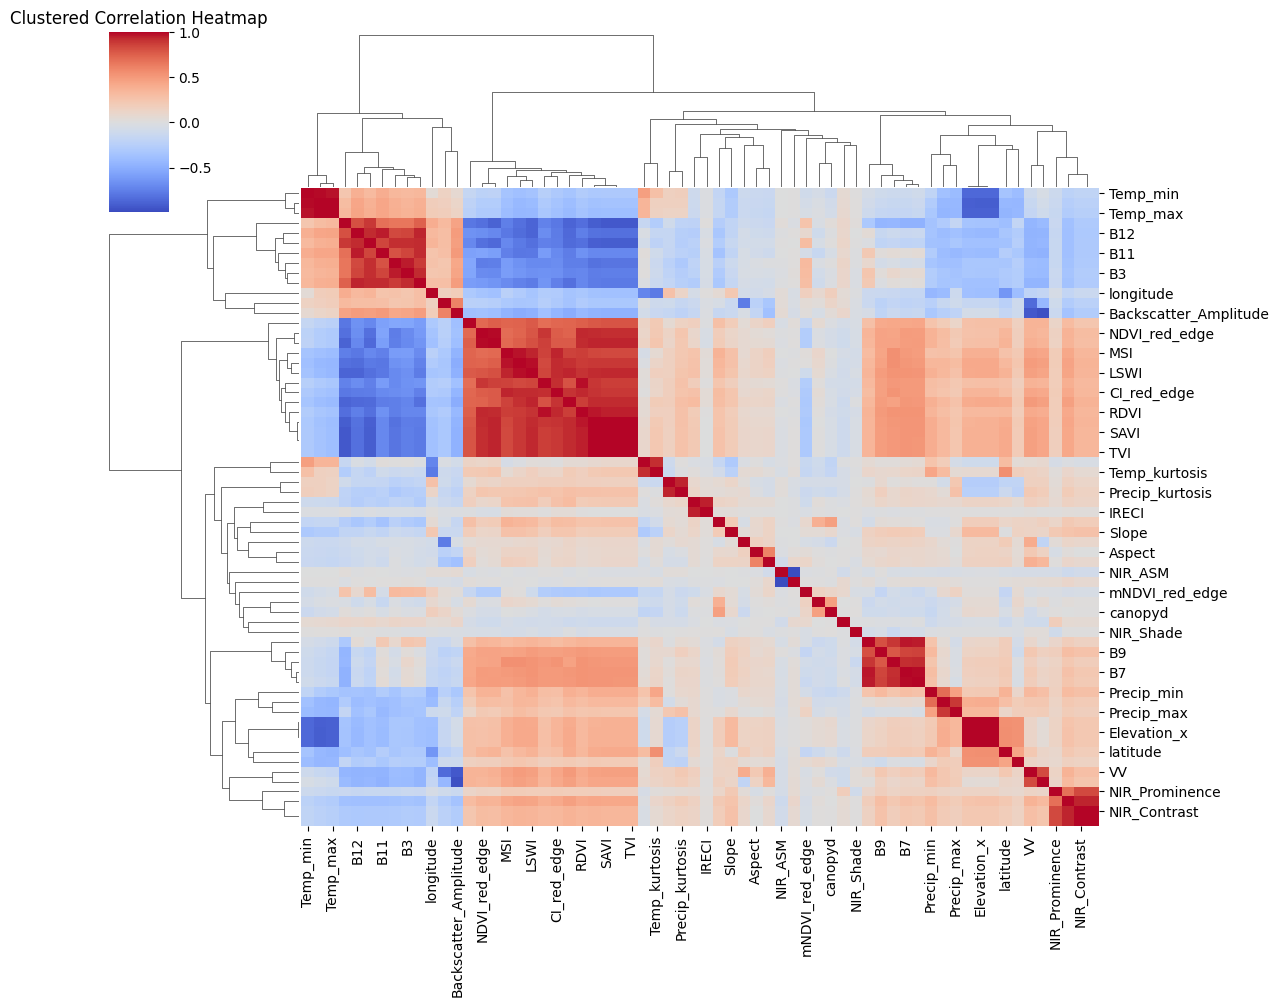

In [ ]:

# Select only numeric columns for correlation
numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
df_numeric = df_cleaned[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(12, 10), annot=False)
plt.title('Clustered Correlation Heatmap')
plt.show()


In [ ]:
df_cleaned.columns

Index(['genus', 'dbh', 'height', 'canopyd', 'latitude', 'longitude',
       'altitude', 'accuracy', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6',
       'B7', 'B8', 'B8A', 'B9', 'NDVI', 'EVI', 'NDWI', 'RDVI', 'NDVI_red_edge',
       'mNDVI_red_edge', 'MSR_red_edge', 'CI_red_edge', 'MSI', 'LSWI', 'MTCI',
       'IRECI', 'PSRI', 'NDVIA', 'TCARI', 'MCARI', 'TVI', 'SAVI', 'Temp_mean',
       'Temp_max', 'Temp_min', 'Temp_skew', 'Temp_kurtosis', 'Elevation_x',
       'Precip_mean', 'Precip_max', 'Precip_min', 'Precip_skew',
       'Precip_kurtosis', 'Elevation_y', 'Slope', 'Aspect', 'Hill_shade', 'VV',
       'VH', 'Backscatter_Difference', 'Backscatter_Division',
       'Backscatter_Amplitude', 'NIR_Contrast', 'NIR_Dissimilarity',
       'NIR_Entropy', 'NIR_Correlation', 'NIR_ASM', 'NIR_Inertia', 'NIR_Shade',
       'NIR_Prominence'],
      dtype='object')

In [17]:
columns_to_drop = ['NDWI', 'RDVI', 'NDVI_red_edge','mNDVI_red_edge', 'MSR_red_edge', 'CI_red_edge', 'MSI', 'LSWI', 'MTCI','Temp_max', 'Temp_min','Precip_max','Precip_min','NIR_Prominence']

# Drop them from the DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [18]:
# Encode genus labels (convert categorical genus names into numbers)
le = LabelEncoder()
df_cleaned['genus'] = le.fit_transform(df_cleaned['genus'])

# View mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'Acacia': np.int64(0), 'Eucalyptus': np.int64(1), 'Grevillea': np.int64(2), 'Musa': np.int64(3)}


In [19]:
# Separate features and target variable
X = df_cleaned.drop(columns=['genus'])
y = df_cleaned['genus']

In [20]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [21]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [22]:
# Feature Scaling
scaler_std = StandardScaler()  # For SVM
scaler_minmax = MinMaxScaler()  # For tree-based models
X_train_svm = scaler_std.fit_transform(X_train)
X_test_svm = scaler_std.transform(X_test)
X_train_tree = scaler_minmax.fit_transform(X_train)
X_test_tree = scaler_minmax.transform(X_test)

# Train and Display Results for SVM

In [23]:
def train_svm():
    print("\nTraining SVM...\n")

    model = SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=42
    )

    model.fit(X_train_svm, y_train)
    y_pred = model.predict(X_test_svm)

    print("\n🔍 Evaluation Metrics for SVM:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_svm()


Training SVM...


🔍 Evaluation Metrics for SVM:
✔️ Accuracy: 0.79875
📊 Kappa Score: 0.7316666666666667
🔁 Macro F1 Score: 0.7971148654021408
🎯 Precision (macro): 0.8001455604336754
📥 Recall (macro): 0.7987500000000001
🔄 MCC: 0.733083804511804

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.92      0.91      0.91       200
  Eucalyptus       0.68      0.73      0.71       200
   Grevillea       0.78      0.65      0.70       200
        Musa       0.83      0.91      0.87       200

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800



# Train and Display Results for Random Forest

In [ ]:
def train_rf():
    print("\n🌲 Training Random Forest...\n")

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    print("\n🔍 Evaluation Metrics for Random Forest:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Run it
train_rf()


🌲 Training Random Forest...


🔍 Evaluation Metrics for Random Forest:
✔️ Accuracy: 0.8325
📊 Kappa Score: 0.7766666666666666
🔁 Macro F1 Score: 0.8322804032127571
🎯 Precision (macro): 0.8347767690427135
📥 Recall (macro): 0.8325
🔄 MCC: 0.7775857329582365

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.93      0.90      0.92       200
  Eucalyptus       0.73      0.82      0.77       200
   Grevillea       0.79      0.70      0.74       200
        Musa       0.89      0.91      0.90       200

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



# Train and Display Results for Gradient Boosting

In [ ]:
def train_gb():
    print("\n⚙️ Training Gradient Boosting...\n")

    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    print("\n🔍 Evaluation Metrics for Gradient Boosting:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Train Gradient Boosting model
train_gb()


⚙️ Training Gradient Boosting...


🔍 Evaluation Metrics for Gradient Boosting:
✔️ Accuracy: 0.83125
📊 Kappa Score: 0.775
🔁 Macro F1 Score: 0.8315563014103721
🎯 Precision (macro): 0.8321432638972326
📥 Recall (macro): 0.83125
🔄 MCC: 0.7750791266998154

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.93      0.90      0.91       200
  Eucalyptus       0.74      0.76      0.75       200
   Grevillea       0.75      0.75      0.75       200
        Musa       0.90      0.93      0.91       200

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



# Train and Display Results for XGBoost

In [ ]:
def train_xgb():
    print("\n⚡ Training XGBoost...\n")

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )

    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    print("\n🔍 Evaluation Metrics for XGBoost:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Call the function to train XGBoost
train_xgb()


⚡ Training XGBoost...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:26:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Evaluation Metrics for XGBoost:
✔️ Accuracy: 0.85125
📊 Kappa Score: 0.8016666666666666
🔁 Macro F1 Score: 0.8510787783799987
🎯 Precision (macro): 0.8526521273067108
📥 Recall (macro): 0.85125
🔄 MCC: 0.8022568768499135

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.94      0.90      0.92       200
  Eucalyptus       0.76      0.83      0.80       200
   Grevillea       0.79      0.73      0.76       200
        Musa       0.92      0.94      0.93       200

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



# Train and Display Results for LightGBM

In [ ]:
def train_lgb():
    print("\nTraining LightGBM...\n")
    model = LGBMClassifier()
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)


    # Calculate evaluation metrics
    print("\nEvaluation Metrics for LightGBM:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

     # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Call the function to train LightGBM
train_lgb()


Training LightGBM...

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12310
[LightGBM] [Info] Number of data points in the train set: 3196, number of used features: 50
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

Evaluation Metrics for LightGBM:
✔️ Accuracy: 0.86375
📊 Kappa Score: 0.8183333333333334
🔁 Macro F1 Score: 0.8635379407074552
🎯 Precision (macro): 0.8650082300919433
📥 Recall (macro): 0.86375
🔄 MCC: 0.8188948099730492

Classification Report:
               precision    recall  f1-score   support

      Acacia       0.95      0.91      0.93       200
  Eucalyptus       0.77      0.84      0.81       200
   Grevillea       0.82      0.75      0.78       200
        Musa

# Hyperparameter tuning

## SVM Hyperparameter Tuning & Training

In [52]:
def train_svm():
    print("\n🔎 Hyperparameter Tuning for SVM...\n")

    param_grid = {
        'C': [0.01, 0.1, 1, 10],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
        'kernel': ['rbf', 'poly', 'sigmoid'],  # Exploring multiple kernels
        'degree': [2, 3, 4],  # Degree for polynomial kernel
        'coef0': [ 0.1, 0.5, 1.0],  # Coefficient for 'poly' and 'sigmoid' kernels
        'shrinking': [True, False],  # Whether to use shrinking heuristic
    }

    grid_search = GridSearchCV(
        SVC(class_weight='balanced', probability=True, random_state=42),
        param_grid, cv=3, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train_svm, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_svm)

    print("\n🏆 Best Hyperparameters for SVM:", grid_search.best_params_)
    print("\n🔍 Evaluation Metrics for SVM:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_svm()


🔎 Hyperparameter Tuning for SVM...


🏆 Best Hyperparameters for SVM: {'C': 10, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}

🔍 Evaluation Metrics for SVM:
✔️ Accuracy: 0.85875
📊 Kappa Score: 0.8116666666666666
🔁 Macro F1 Score: 0.8581985182963177
🎯 Precision (macro): 0.8595913604766672
📥 Recall (macro): 0.85875
🔄 MCC: 0.8123184752843828

📃 Classification Report:
               precision    recall  f1-score   support

      Acacia       0.94      0.91      0.92       200
  Eucalyptus       0.77      0.83      0.80       200
   Grevillea       0.81      0.73      0.77       200
        Musa       0.93      0.96      0.94       200

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



##  Random Forest Hyperparameter Tuning & Training

In [ ]:
def train_rf():
    print("\n🔎 Hyperparameter Tuning for Random Forest...\n")

    param_grid = {
      'n_estimators': [100, 200],  # Number of trees
      'max_depth': [10, 20, None],  # Depth of trees
     'min_samples_split': [2, 5],  # Minimum samples required to split a node
     'min_samples_leaf': [1, 2],  # Minimum samples per leaf
     'max_features': ['sqrt'],  # Number of features to consider per split
     'bootstrap': [True],  # Whether to use bootstrapped samples
     'criterion': ['gini', 'entropy'],  # Splitting criterion
  }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid, cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train_tree, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_tree)

    print("\n🏆 Best Hyperparameters for RF:", grid_search.best_params_)
    print("\n🔍 Evaluation Metrics for RF:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_rf()


🔎 Hyperparameter Tuning for Random Forest...



## Gradient Boosting Hyperparameter Tuning & Training

In [ ]:
def train_gb():
    print("\n🔎 Hyperparameter Tuning for Gradient Boosting...\n")

    param_grid = {
      'n_estimators': [100, 200, 300],  # More estimators for better learning
      'learning_rate': [0.01, 0.1, 0.2],  # Finer control over step size
      'max_depth': [3, 5, 7],  # Deeper trees capture more complexity
      'min_samples_split': [2, 5, 10],  # Prevents overfitting
      'min_samples_leaf': [1, 2, 4],  # Controls minimum data in a leaf
      'subsample': [0.8, 1.0],  # Controls randomness in row sampling
      'max_features': ['sqrt', 'log2', None]  # Feature selection per tree
    }
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),
                               param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_tree, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_tree)

    print("\n🏆 Best Hyperparameters for GB:", grid_search.best_params_)
    print("\n🔍 Evaluation Metrics for GB:")
    print("✔️ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Kappa Score:", cohen_kappa_score(y_test, y_pred))
    print("🔁 Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🎯 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("📥 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("🔄 MCC:", matthews_corrcoef(y_test, y_pred))

    print("\n📃 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

train_gb()